# State Farm Distracted Driver Detection - Simple VGG16

This shows plots in the web page itself - we always wants to use this when using jupyter notebook:

In [1]:
%matplotlib inline

Define path to data: (It's a good idea to put it in a subdirectory of your notebooks folder, and then exclude that directory from git control by adding it to .gitignore.)

In [2]:
#path = "data/"
path = "data/sample/"

A few basic libraries that we'll need for the initial exercises:

In [3]:
from __future__ import division,print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

We have created a file most imaginatively called 'utils.py' to store any little convenience functions we'll want to use. We will discuss these as we use them.

In [4]:
import utils; reload(utils)
from utils import plots

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


# Use a pretrained VGG model with our **Vgg16** class

Our first step is simply to use a model that has been fully created for us, which can recognise a wide variety (1,000 categories) of images. We will use 'VGG', which won the 2014 Imagenet competition, and is a very simple model to create and understand. The VGG Imagenet team created both a larger, slower, slightly more accurate model (*VGG  19*) and a smaller, faster model (*VGG 16*). We will be using VGG 16 since the much slower performance of VGG19 is generally not worth the very minor improvement in accuracy.

We have created a python class, *Vgg16*, which makes using the VGG 16 model very straightforward. 

## Use Vgg16 for basic image recognition

Let's start off by using the *Vgg16* class to recognise the main imagenet category for each image.

We won't be able to enter the Distracted Driver competition with an Imagenet model alone, since 'talking on the phone ' and 'texting' are not categories in Imagenet. However, we can use it to see how well it can recognise the images, which is a good first step.

First, create a Vgg16 object:

In [5]:
# Import our class, and instantiate
import vgg16; reload(vgg16)
from vgg16 import Vgg16
vgg = Vgg16()

Vgg16 is built on top of *Keras* (which we will be learning much more about shortly!), a flexible, easy to use deep learning library that sits on top of Theano or Tensorflow. Keras reads groups of images and labels in *batches*, using a fixed directory structure, where images from each category for training must be placed in a separate folder.

Let's grab batches of data from our training folder:

In [6]:
batches = vgg.get_batches(path+'train', batch_size=4)

Found 500 images belonging to 10 classes.


(BTW, when Keras refers to 'classes', it doesn't mean python classes - but rather it refers to the categories of the labels, such as 'pug', or 'tabby'.)

*Batches* is just a regular python iterator. Each iteration returns both the images themselves, as well as the labels.

Lets convert the bit-vector label into human-readable label, using Kaggle's data description page:

c0: safe driving
c1: texting - right
c2: talking on the phone - right
c3: texting - left
c4: talking on the phone - left
c5: operating the radio
c6: drinking
c7: reaching behind
c8: hair and makeup
c9: talking to passenger

In [7]:
def convertCategetoryIDToTextDescription(category_id):
    return {
        0: 'safe driving',
        1: 'texting - right',
        2: 'talking on the phone - right',
        3: 'texting - left',
        4: 'talking on the phone - left',
        5: 'operating the radio',
        6: 'drinking',
        7: 'reaching behind',
        8: 'hair and makeup',
        9: 'talking to passenger'
    }.get(category_id, 'unknown')

In [8]:
imgs,labels = next(batches)

In [9]:
category_array = np.where(labels==1)[1]
labels = [convertCategetoryIDToTextDescription(x) for x in category_array]

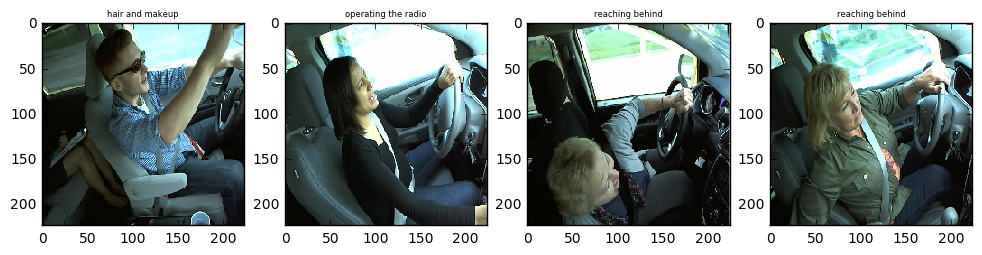

In [10]:
plots(imgs, titles=labels)

We can now pass the images to Vgg16's predict() function to get back probabilities, category indexes, and category names for each image's VGG prediction.

In [11]:
vgg.predict(imgs, True)

(array([ 0.8431,  0.9998,  0.9795,  0.991 ], dtype=float32),
 array([785, 785, 785, 785]),
 [u'seat_belt', u'seat_belt', u'seat_belt', u'seat_belt'])

The category indexes are based on the ordering of categories used in the VGG model - e.g here are the first four:

In [12]:
vgg.classes[:4]

[u'tench', u'goldfish', u'great_white_shark', u'tiger_shark']

(Note that, other than creating the Vgg16 object, none of these steps are necessary to build a model; they are just showing how to use the class to view imagenet predictions.)

## Use our Vgg16 class to finetune a Distracted Driver Model

To change our model so that it outputs the 10 categories of driving state, instead of one of 1,000 very specific categories, we need to use a process called "finetuning". Finetuning looks from the outside to be identical to normal machine learning training - we provide a training set with data and labels to learn from, and a validation set to test against. The model learns a set of parameters based on the data provided.

However, the difference is that we start with a model that is already trained to solve a similar problem. The idea is that many of the parameters should be very similar, or the same, between the existing model, and the model we wish to create. Therefore, we only select a subset of parameters to train, and leave the rest untouched. This happens automatically when we call *fit()* after calling *finetune()*.

We create our batches just like before, and making the validation set available as well. A 'batch' (or *mini-batch* as it is commonly known) is simply a subset of the training data - we use a subset at a time when training or predicting, in order to speed up training, and to avoid running out of memory.

##### Note: on P2Xlarge, there is 12G of GPU memory. Batch size of 256 causes out-of-memory error.

In [13]:
batch_size=196

In [14]:
batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size)

Found 500 images belonging to 10 classes.
Found 100 images belonging to 10 classes.


Calling *finetune()* modifies the model such that it will be trained based on the data in the batches provided - in this case, to predict either 'dog' or 'cat'.

In [15]:
vgg.finetune(batches)

Finally, we *fit()* the parameters of the model using the training data, reporting the accuracy on the validation set after every epoch. (An *epoch* is one full pass through the training data.)

In [16]:
vgg.fit(batches, val_batches, nb_epoch=4)

Epoch 1/4
500/500 [==============================] - 18s - loss: 6.0084 - acc: 0.1220 - val_loss: 3.6758 - val_acc: 0.1000
Epoch 2/4
500/500 [==============================] - 16s - loss: 4.6347 - acc: 0.1900 - val_loss: 3.3741 - val_acc: 0.1500
Epoch 3/4
500/500 [==============================] - 16s - loss: 3.8754 - acc: 0.2820 - val_loss: 3.4421 - val_acc: 0.2200
Epoch 4/4
500/500 [==============================] - 16s - loss: 3.1492 - acc: 0.3680 - val_loss: 3.6951 - val_acc: 0.2300


Lets test the re-trained Distracted Driver Model.

In [17]:
vgg.model.save_weights(path+'models/simple_vgg16_epoch_1_train_2906.h5')

In [18]:
#test_path = "data/test"
test_path = "data/sample/test"

In [19]:
test_batches, test_preds = vgg.test(test_path, batch_size = batch_size*2)

Found 25 images belonging to 1 classes.


In [20]:
# grab filenames
test_filenames = test_batches.filenames


For each image, pull out the winning category and use it for labeling.

In [21]:
# argmax returns index of category with highest probability
# which happens to be same as State Farm defined cateogry id itself
test_pred_winning_category_id = test_preds.argmax(axis=1)
test_pred_winning_categories = [convertCategetoryIDToTextDescription(x) for x in test_pred_winning_category_id]

In [22]:
test_pred_winning_prob = np.choose(test_pred_winning_category_id, test_preds.transpose())

In [23]:
from keras.preprocessing import image

#Helper function to plot subset of images by index
#Plots is a helper function in utils.py
def plots_idx(idx, path, filenames, categories, probabilities):
    my_image_ids = np.array([int(filenames[i][filenames[i].find('_')+1:filenames[i].find('.')]) for i in idx])
    my_categories = [categories[i] for i in idx]
    my_probabilities = [probabilities[i] for i in idx]
    
    # label = <iamge id>=<category>:<probability>
    my_labels = ["{}={}:{:0.5f}".format(i, j, k) for i,j,k in zip(my_image_ids, my_categories, my_probabilities)]
    
    plots([image.load_img(path + filenames[i]) for i in idx], titles=my_labels)
    


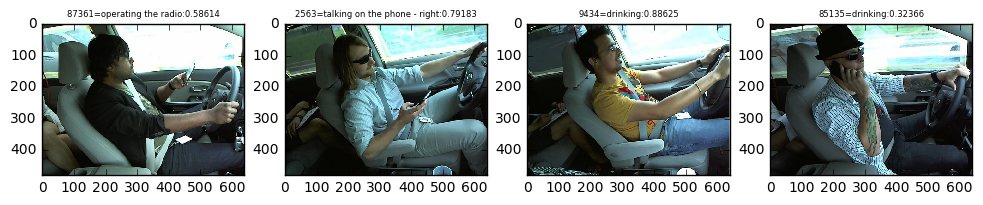

In [24]:
#Number of images to view for each visualization task
n_view = 4

#print out prediction of a few test images
idx = np.random.permutation(range(0,len(test_filenames)))[:n_view]
plots_idx(idx, path+'test/', test_filenames, test_pred_winning_categories, test_pred_winning_prob)

In [25]:
# prepare data for Kaggle submission

#So to play it safe, we use a sneaky trick to round down our edge predictions
#Swap all ones with .95 and all zeros with .05
test_predictions = test_preds.clip(min=0.05, max=0.95)



In [26]:
# strip directory name
test_filenames = [filename[filename.find('/')+1:] for filename in test_filenames]

In [27]:
subm1 = np.zeros(len(test_filenames), dtype=[('filename', 'S128'), ('c0', float), ('c1', float), ('c2', float), ('c3', float), ('c4', float), ('c5', float), ('c6', float), ('c7', float), ('c8', float), ('c9', float)])

subm1['filename'] = test_filenames

subm1['c0'] = test_predictions[:,0]
subm1['c1'] = test_predictions[:,1]
subm1['c2'] = test_predictions[:,2]
subm1['c3'] = test_predictions[:,3]
subm1['c4'] = test_predictions[:,4]
subm1['c5'] = test_predictions[:,5]
subm1['c6'] = test_predictions[:,6]
subm1['c7'] = test_predictions[:,7]
subm1['c8'] = test_predictions[:,8]
subm1['c9'] = test_predictions[:,9]

In [28]:
# write Kaggle submission file
submission_file_name = 'submission1.csv'
np.savetxt(submission_file_name, subm1, fmt='%s,%.5f,%.5f,%.5f,%.5f,%.5f,%.5f,%.5f,%.5f,%.5f,%.5f', header='img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9', comments='')